In [13]:
import ta
import sys

from sklearn import preprocessing
from sklearn.svm import SVC
from scipy.signal import argrelextrema

sys.path.append("..")
from utils import Db
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [14]:
db = Db("../cache")
df = db.get_symbols_as_dataframe(['HPQ'])
df['date_time'] = pd.to_datetime(df['date_time'])
df = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume')
scatter_data = df[['unix_time', 'adjusted_close', 'date_time']].as_matrix()
dates = scatter_data[:, 2]

df = df.set_index('date_time')
df['make_a_trade'] = 3

mins = argrelextrema(df['adjusted_close'].as_matrix(), np.less, order=5)
mins_dates = dates[mins[0]]
mins_vals = scatter_data[mins[0], 1]
maxes = argrelextrema(df['adjusted_close'].as_matrix(), np.greater, order=5)
maxes_dates = dates[maxes[0]]
maxes_vals = scatter_data[maxes[0], 1]

df['make_a_trade'][mins_dates] = 1
df['make_a_trade'][maxes_dates] = 2
df = df.dropna()
columns = ['volume_adi', 'volume_obv', 'volume_obvm', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_vpt',
           'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl', 'volatility_bbm', 'volatility_bbhi',
           'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
           'volatility_kcli', 'volatility_dch', 'volatility_dcl', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
           'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx', 'trend_adx_pos',
           'trend_adx_neg', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_diff', 'trend_trix',
           'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff',
           'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b',
           'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_ind', 'momentum_rsi', 'momentum_mfi', 'momentum_tsi',
           'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'others_dr',
           'others_dlr', 'others_cr', 'make_a_trade']
source_data = df[columns].as_matrix()
training_data = source_data[:int(len(source_data) * .98), 0:-1]
testing_data = source_data[len(training_data):, 0:-1]
target = source_data[:int(len(source_data) * .98), -1]
testing_target = source_data[len(training_data):, -1]

min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(training_data)

plt.rcParams["figure.figsize"] = [9, 6]
%matplotlib notebook

C:\python36_64\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\python36_64\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
svr_rbf = SVC(kernel='rbf')
svr_rbf.fit(x_train_minmax, target)

test_output = svr_rbf.predict(min_max_scaler.transform(testing_data))
errors = np.abs(testing_target - test_output)
print(np.std(errors))
print(np.mean(errors))

0.506287004191
0.171428571429


<IPython.core.display.Javascript object>


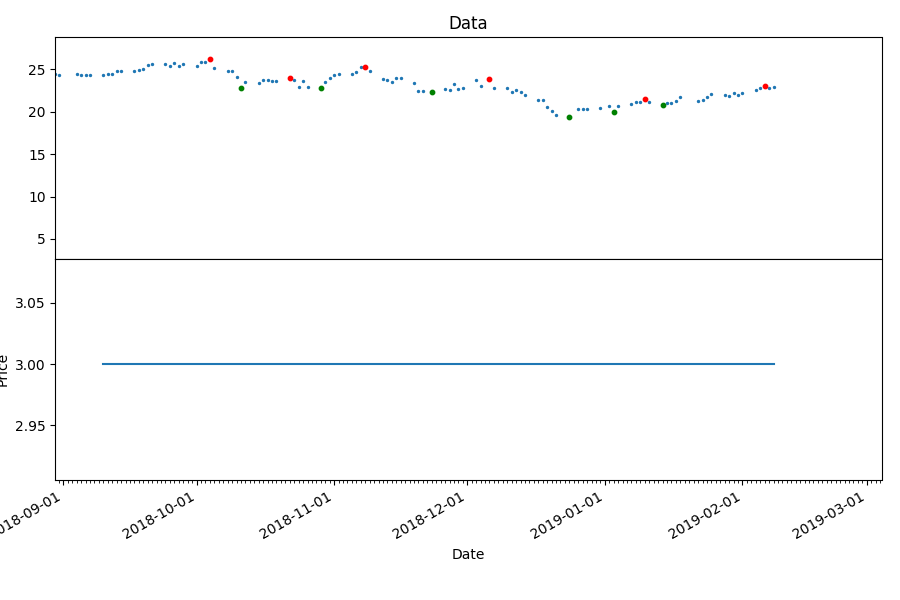

In [16]:
years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
yearsFmt = mdates.DateFormatter('%Y-%m-%d')
fig = plt.figure()
ax = fig.add_subplot(211)

ax.scatter(dates, scatter_data[:, 1].tolist(), label='Price', s=2)
ax.scatter(maxes_dates, maxes_vals.tolist(), label='Maxes', s=10, color='red')
ax.scatter(mins_dates, mins_vals.tolist(), label='Mins', s=10, color='green')

plt.title('Data')

ax = fig.add_subplot(212, sharex=ax)
test_dates = dates[-len(testing_data):]
ax.plot(test_dates, test_output)

left = dates[-120]
right = dates[-1] + timedelta(days=5)
ax.set_xlim(left=left, right=right)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(yearsFmt)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()